## demo using the post-processed data archive (pp_archive) to assess efffectiveness of SAI across a range of impacts


To show an example of one potential usage, here we reproduce a figure from Irvine et al. (https://www.nature.com/articles/s41558-019-0398-8) showing, for each IPCC region, how SAI is modelled to change a set of climate variables. The approach here is to assign effectiveness labels to each grid point or region based on the ratio of change under warming to change under SAI. For example, if the two values are within 25% of each other in magnitude, and of the opposite sign, then we could call this 'Effective'. Whereas if the two changes are the same sign, we say that SAI 'exacerbates' global warming in this region. 

There are several major caveats to the below code, which are open issues to resolve before the outputs should be taken seriously:

1. There are unresolved problems in the ETCCDI data which sits behind this need to be fixed, meaning the temperature extreme indices shown are likely wrong. 
2. We do not here apply any test of statistical significance, which should be added, since the ~100 year period (5 members x 20 years) over which each of these metrics is assessed may be fairly short for some variables (e.g. RX1day)
3. we here just use CESM2-WACCM data for the regional plot. The ETCCDI indeces have so far only been calculated for CESM2_WACCM, but this means we have no way yet to account for intermodel uncertainty in the regional plot.


Author:
Alistair Duffey

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import xarray as xr
from xmip.preprocessing import rename_cmip6
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import pandas as pd

from utils import get_data
from utils import CESMize_var_names
from utils import adjust_longitude

/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


NB

we use the nomenclature 'target', 'warming', and 'SAI' to refer consistently to the states which we compare. These three states apply in both ARISE (where they are the 1.5C period world, the late century world under SSP245, and the late century world under ARISE-1.5-SAI, respectively), and in G6sulfur (where they are SSP245-late-century, SSP585-late-century and G6sulfur-late-century). 

In [3]:
def fraction_of_land(masked_array, sftlf):
    """ 
    returns fraction of total land area covered by a masked array in which missing values have been dropped
    inputs:
    dsm: masked array
    population_weighted: boolean option TO ADD
    
    outputs:
    single value, giving fraction of the land area covered by the masked array
    """

    # Convert land fraction to [0, 1] range
    land_fraction = sftlf / 100.0

    # Calculate cosine of latitude for weighting
    cos_lat = np.cos(np.deg2rad(masked_array['y']))

    # Expand dimensions of cos_lat to align with masked_array, if necessary
    cos_lat = cos_lat.broadcast_like(masked_array)

    # Weight by land fraction and cos(latitude)
    weighted_area = (masked_array.notnull() * land_fraction * cos_lat).sum()

    # Total possible land area weight (for normalization)
    total_land_area = (land_fraction * cos_lat).sum()

    # Fraction of land area covered by the mask
    land_area_fraction = weighted_area / total_land_area

    return land_area_fraction.item()


In [6]:
def get_fractions(model, effectiveness_cats_dict,
                  var = 'tas', season = 'annual',
                  table = 'Amon',
                  experiment_group = 'ARISE'):
    """ returns a dataframe of fractions of global land area falling
        into categories of effectiveness 

        Inputs:
        model : string, any G6 model
        effectiveness_cats_dict: dict, list of cateogry names, and associated upper and lower bounds on changes
        var: string, any BCEV, cmor names (e.g. 'tas')
        season: string, 'annual', 'DJF', 'MAM', 'JJA', 'SON'
        experiment_group: 'ARISE' or 'GeoMIP'
    """
    
    land_area = xr.open_dataset('../pp_archive/fx/{a}/sftlf/{b}_sftlf.nc'.format(a=model, b=model))
    
    
    
    if experiment_group == 'ARISE':  
        if model == 'CESM2-WACCM':
            if table == 'Amon':
                var = CESMize_var_names(var)
        target, warming, SAI = get_data(group='ARISE', model=model, 
                                        windows =['SSP245_baseline', 'SSP245_background', 'ARISE_assmt'],
                                        table=table, variable=var, 
                                        mean_or_std='mean', season=season)
        
    if experiment_group == 'GeoMIP':
        target, warming, SAI = get_data(group='GeoMIP', model=model, 
                                        windows =['SSP245_target', 'SSP585_background', 'G6sulfur_assmt'],
                                        table=table, variable=var, 
                                        mean_or_std='mean', season=season)

    
    change_warming = warming - target
    change_SAI = warming - SAI
    change_ratio = (change_SAI/change_warming).compute()

    effectiveness_cats = list(effectiveness_cats_dict.keys())

    category_names = []
    category_fractions = []
    
    for cat in effectiveness_cats:
        region_in_cat = change_ratio.where((change_ratio[var]>effectiveness_cats_dict[cat][0])&(change_ratio[var]<effectiveness_cats_dict[cat][1]))
        fraction_in_cat = fraction_of_land(masked_array=region_in_cat[var], sftlf=land_area.sftlf)
        category_names.append(cat)
        category_fractions.append(fraction_in_cat)

    df = pd.DataFrame({'Effectiveness':category_names,
                       'Fraction_of_land_area':category_fractions})
    df['Model'] = model
    
    return df

/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/a_duffey/.con

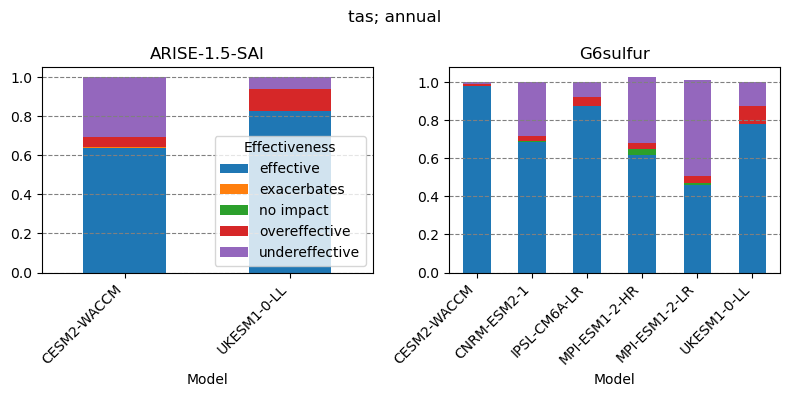

/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/a_duffey/.conda/envs/cmipv2/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/users/a_duffey/.c

In [5]:
# settings 
var = 'tas'
season = 'annual'

effectiveness_cats_dict = {'overeffective':[1.25, np.inf],
                           'effective':[0.75, 1.25],
                           'undereffective':[0, 0.75],
                           'no impact':[-0.25, 0.25],
                           'exacerbates':[-np.inf, -0.25]}


# run over UKESM and CESM ARISE
df_arise_list = []
for model in ['UKESM1-0-LL', 'CESM2-WACCM']:
    df_arise_list.append(get_fractions(model, effectiveness_cats_dict=effectiveness_cats_dict,
                                       var = var, season = season, experiment_group = 'ARISE'))
df_arise = pd.concat(df_arise_list).reset_index(drop=True)

# run over the G6sulfur models
df_G6_list = []
for model in ['IPSL-CM6A-LR', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'CESM2-WACCM', 'CNRM-ESM2-1']:
    df_G6_list.append(get_fractions(model, effectiveness_cats_dict=effectiveness_cats_dict,
                                    var = var, season = season, experiment_group = 'GeoMIP'))
df_G6 = pd.concat(df_G6_list).reset_index(drop=True)

## and make a basic plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

df_pivot = df_arise.pivot(index='Model', columns='Effectiveness', values='Fraction_of_land_area')
df_pivot.plot(ax=axs[0], kind='bar', stacked=True)
axs[0].set_title('ARISE-1.5-SAI')
df_pivot = df_G6.pivot(index='Model', columns='Effectiveness', values='Fraction_of_land_area')
df_pivot.plot(ax = axs[1], kind='bar', stacked=True, legend=False)
axs[1].set_title('G6sulfur')

for ax in axs:
    ax.grid(axis='y', linestyle='--', color='gray')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle(var+'; '+season)
plt.tight_layout()
plt.savefig('Figures/Demo.jpg', dpi=250)

I think that the large amount of 'undereffective' land area, particularly for MPI and CNRM comes from imperfectly controlled SAI magnitude in these simulations. I.e. there is global under-cooling, because of imperfect control of the injection magnitude by those running the models.

## Now try a demo of the multi-variable assessment:


KeyError: 'Model'

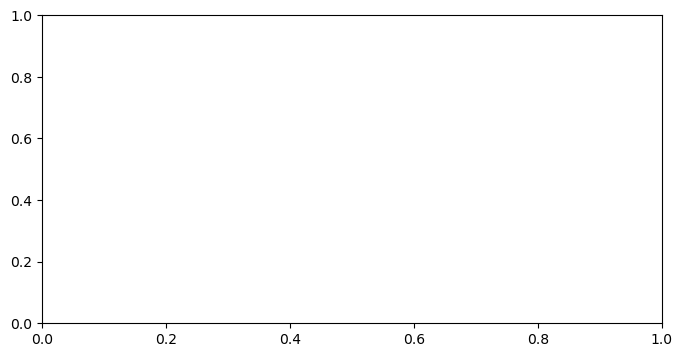

In [32]:
# settings 
season = 'annual'
model = 'CESM2-WACCM'

effectiveness_cats_dict = {'overeffective':[1.25, np.inf],
                           'effective':[0.75, 1.25],
                           'undereffective':[0, 0.75],
                           'no impact':[-0.25, 0.25],
                           'exacerbates':[-np.inf, -0.25]}

variables_and_feats = {'tas':['Amon','Mean surface temperature'],
                        'TXX':['ETCCDI','Extreme heat'],
                        'TNN':['ETCCDI','Cold spell'],
                        'pr':['Amon','Mean precipitation'],
                        'RX1D':['ETCCDI','Heavy precipitation'],
                        'RX5D':['ETCCDI','River flood'],
                        'CDD':['ETCCDI','Hydrological drought'],
                       }

i=0
for var in variables_and_feats.keys():
    df = get_fractions(model, effectiveness_cats_dict=effectiveness_cats_dict,
                                       var = var, season = season, table = variables_and_feats[var][0],
                                       experiment_group = 'ARISE')
    df = df.rename(columns={'Fraction_of_land_area':'{}'.format(variables_and_feats[var][1])}).drop(columns=['Model'])
    if i == 0:
        df_arise = df.copy()
    else:
        df_arise = pd.merge(df_arise, df, how='outer')
    i=i+1

## and make a basic plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

df_pivot = df_arise.pivot(index='Model', columns='Effectiveness', values='Fraction_of_land_area')
df_pivot.plot(ax=axs[0], kind='bar', stacked=True)
ax.set_title('ARISE-1.5-SAI')
ax.grid(axis='y', linestyle='--', color='gray')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle(var+'; '+season)
plt.tight_layout()
plt.savefig('Figures/Demo_multi_var.jpg', dpi=250)

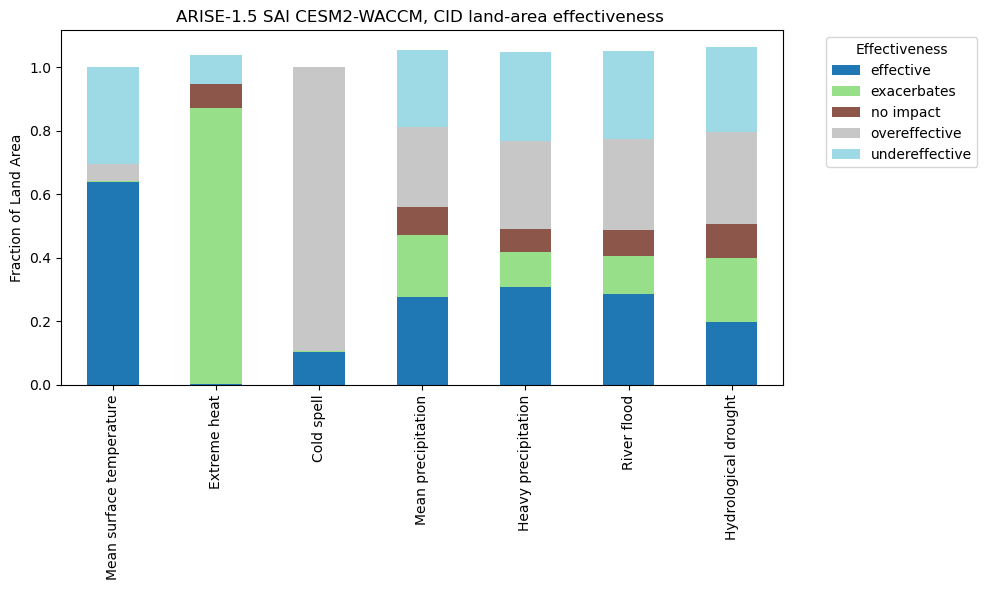

In [33]:
df = df_arise.copy()

# Set the index to "Effectiveness" for plotting
df.set_index("Effectiveness", inplace=True)


# Transpose the DataFrame for plotting
df_t = df.T

# Plot a stacked bar chart
ax = df_t.plot(kind="bar", stacked=True, figsize=(10, 6), cmap="tab20")

# Add labels and title
plt.ylabel("Fraction of Land Area")
#plt.xlabel("Variables")
plt.title("ARISE-1.5 SAI CESM2-WACCM, CID land-area effectiveness ")
plt.legend(title="Effectiveness", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()

### Below, we move on to the regional version:

In [7]:
# need some more packages to handle the shapefile IPCC region data

import pyproj

# the line below is a local fix to set the pyproj installation to the correct place
# because my local system was going to the wrong installation of pyproj
# it should be unneccesary on other systems, and will throw an error from the filepath
pyproj.datadir.set_data_dir('/home/users/a_duffey/.conda/envs/cmipv2/share/proj')

import rioxarray
from rasterio.features import geometry_mask
import geopandas as gpd

In [14]:
### v0:

variables_dict = {'tas':'Amon',
                  'pr':'Amon',
                  'TXX':'ETCCDI',
                  'RX1D' :'ETCCDI'}

# read in IPCC reference regions
shapefile_path = 'extra_data/IPCC_ref_regions/referenceRegions.shp'
gdf = gpd.read_file(shapefile_path)
gdf['centroid'] = gdf.geometry.centroid


for var in variables_dict.keys():
    table = variables_dict[var]
    if table == 'Amon':
        var = CESMize_var_names(var)
    
    target, warming, SAI = get_data(group='ARISE', model='CESM2-WACCM', 
                                                windows =['SSP245_baseline', 'SSP245_background', 'ARISE_assmt'],
                                                table=table, variable=var, 
                                                mean_or_std='mean', season=season)
    
    ### HACK TO FIX MISLABELLED ETCCDI indices:
    ### as of tues 21 jan
    ### remove this shortly when updated dataset
    ### is provided. 
    if var == 'TXX':
        warming, SAI = SAI, warming
        print('NOTE: swapping mislabelled SAI and SSP245 temp indices') 
    ###
    ###
    
    ## get values for 'effectiveness'
    change_warming = warming - target
    change_SAI = warming - SAI
    change_ratio = (change_SAI/change_warming).compute()
    
    ds = adjust_longitude(change_ratio)
    
    # Loop through each geometry (region) in the GeoDataFrame
    region_means = []
    for _, row in gdf.iterrows():
        region_geometry = row['geometry']
        
        mask = geometry_mask([region_geometry], transform=ds.rio.transform(), invert=True, out_shape=ds[var].shape)
        masked_data = ds[var].where(mask)
    
        region_mean = masked_data.mean().values
        region_mean_name = next((key for key, (low, high) in effectiveness_cats_dict.items() if low <= region_mean < high), None)
        region_means.append({
            'LAB': row['LAB'],  
            '{}_value'.format(var): region_mean,
            '{}_label'.format(var):region_mean_name,
        })
    
    df = pd.DataFrame(region_means)

    # join results back onto the gdf:
    
    gdf = pd.merge(gdf, df, how='inner', on='LAB')

/tmp/ipykernel_932/2702822268.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


NOTE: swapping mislabelled SAI and SSP245 temp indices


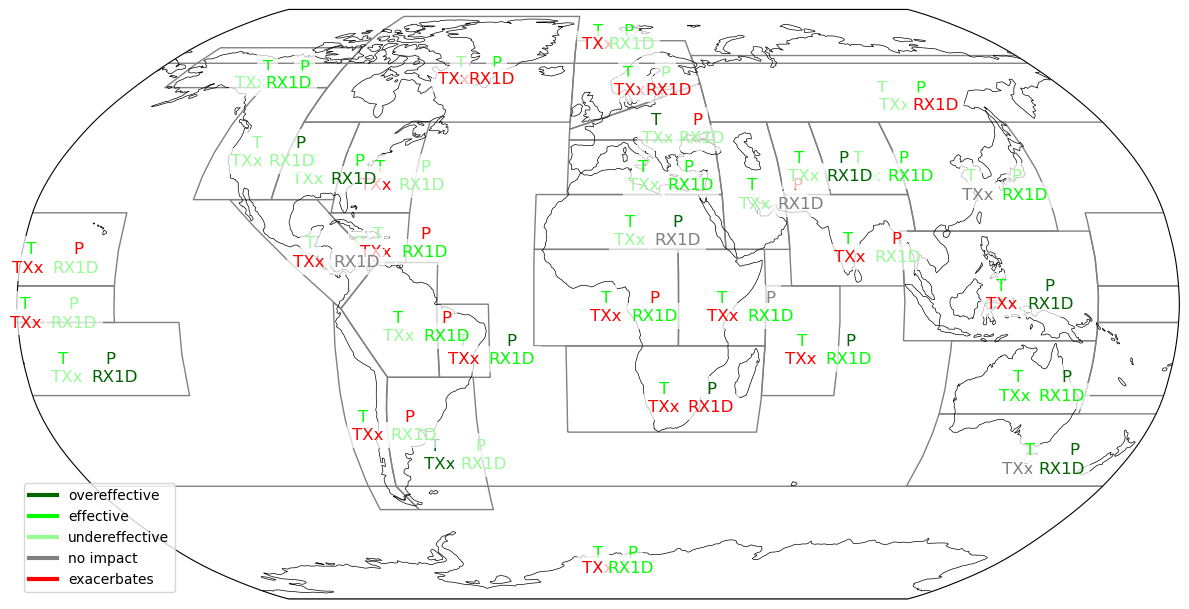

In [18]:
### now plot:

colordict = {'overeffective':'darkgreen',
             'effective':'lime',
             'undereffective':'palegreen',
             'no impact':'grey',
             'exacerbates':'red'}

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={"projection": ccrs.Robinson()})
#ax.add_feature(cfeature.BORDERS, linestyle='--')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# Loop through each region and plot its geometry with color based on 'mean_value'
gdf.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=1, transform=ccrs.PlateCarree())

i=0
offsets_x = [0, 15, 
             0, 15]
offsets_y = [0, 0, 
             -5, -5]
labels = {'TREFHT':'T',
          'PRECT':'P',
          'TXX':'TXx',
          'RX1D':'RX1D'}

for var in variables_dict.keys():
    if variables_dict[var] == 'Amon':
        var = CESMize_var_names(var)
    
    offset_x = offsets_x[i]
    offset_y = offsets_y[i]
    
    
    for _, row in gdf.iterrows():
        color = colordict[row['{}_label'.format(var)]]
        centroid = row['centroid']
        ax.text(
            centroid.x+offset_x, centroid.y+offset_y, '{}'.format(labels[var]), 
            transform=ccrs.PlateCarree(), 
            fontsize=12, ha='center', va='center', color=color,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
        )

    
    i=i+1


for key in colordict.keys():
    ax.plot([], [], lw=3, c=colordict[key], label=key)

ax.legend(loc='lower left')       
ax.set_global()

plt.savefig('Figures/Demo_spatial_v0.jpg', dpi=300)
plt.show()

